In [4]:
import numpy as np
import os
from typing import Tuple
import tensorflow as tf
from sklearn.utils import class_weight

In [5]:
from constants import *

# LSTM Classification

In [33]:
x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-800:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-800:]

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



In [34]:
class_weights_np = np.array(class_weights)
# class_weights_np[-1] = 2.2
class_weights = tf.convert_to_tensor(class_weights_np.astype('float32'))
class_weights

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.6      , 1.7391304, 0.4532578, 1.2698413, 1.2403101],
      dtype=float32)>

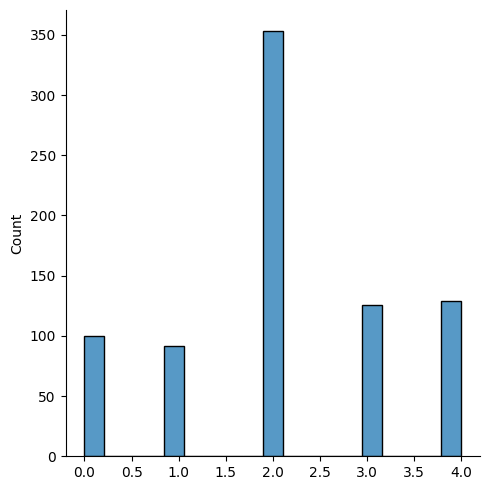

In [35]:
import seaborn as sns
sns.displot(y_training)

In [36]:
class_weights = tf.cast(tf.constant(class_weights), "float32")

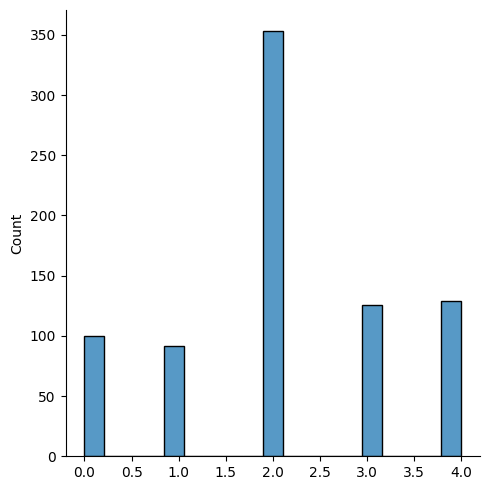

In [37]:
import seaborn as sns

sns.displot(y_training)

In [38]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.005)
lr_scheduler_exp = tf.keras.optimizers.schedules.ExponentialDecay(0.005, 100, 0.9, staircase=True)

In [40]:
def create_lstm_model(input_shape:Tuple[int, int]) -> tf.keras.Model:
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.LSTM(128, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(256, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(512, activation="tanh", return_sequences=False),
        # tf.keras.layers.LSTM(128, activation="tanh"),
        # tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax")
    ])

    model.compile(
        # loss=weightedLoss(class_weights),
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON),
        metrics=["acc"]
    )

    return model

In [41]:
model = create_lstm_model(INPUT_DIM)

In [42]:

history = model.fit(x_training, 
                    y_training, 
                    validation_split=VALIDATION_SPLIT,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_batch_size=BATCH_SIZE,
                    # callbacks=[lr_scheduler]
                    )

Epoch 1/50
20/20 [==============================] - 4s 80ms/step - loss: 1.4955 - acc: 0.4292 - val_loss: 1.4679 - val_acc: 0.4375
Epoch 2/50
20/20 [==============================] - 1s 29ms/step - loss: 1.4441 - acc: 0.4417 - val_loss: 1.4681 - val_acc: 0.4375
Epoch 3/50
20/20 [==============================] - 1s 34ms/step - loss: 1.4009 - acc: 0.4597 - val_loss: 1.4863 - val_acc: 0.4375
Epoch 4/50
20/20 [==============================] - 1s 49ms/step - loss: 1.3783 - acc: 0.4278 - val_loss: 1.5450 - val_acc: 0.3625
Epoch 5/50
20/20 [==============================] - 1s 44ms/step - loss: 1.2867 - acc: 0.4819 - val_loss: 1.4950 - val_acc: 0.3750
Epoch 6/50
20/20 [==============================] - 1s 44ms/step - loss: 1.3339 - acc: 0.4694 - val_loss: 1.8529 - val_acc: 0.3625
Epoch 7/50
20/20 [==============================] - 1s 49ms/step - loss: 1.3439 - acc: 0.4639 - val_loss: 1.8626 - val_acc: 0.3375
Epoch 8/50
20/20 [==============================] - 1s 44ms/step - loss: 1.3313 - a

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 27, 128)           84480     
                                                                 
 lstm_4 (LSTM)               (None, 27, 256)           394240    
                                                                 
 lstm_5 (LSTM)               (None, 512)               1574912   
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2,086,789
Trainable params: 2,086,789
Non-trainable params: 0
_________________________________________________________________


In [44]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

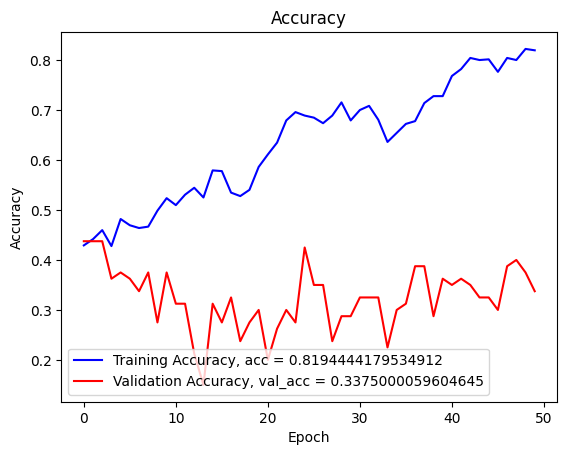

In [45]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

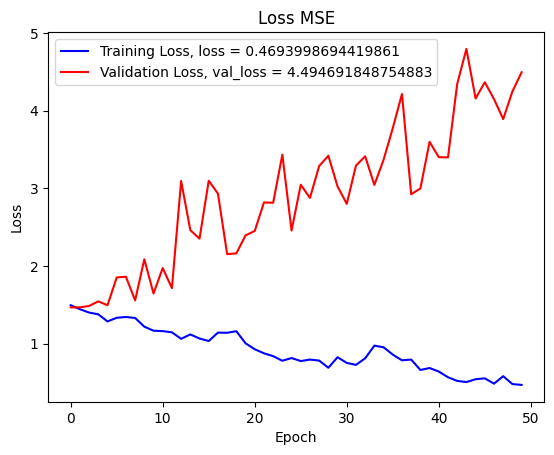

In [46]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [47]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)

INPUT_DIM = x_test.shape[1:]

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))
# y_test = tf.one_hot(y_test, 5)

In [48]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 25ms/step - loss: 3.8466 - acc: 0.3013


[3.8465847969055176, 0.3012658357620239]

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax(y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = classification_report(y_test, y_prediction)
print(result)

13/13 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.10      0.11      0.10        47
           1       0.22      0.13      0.16        53
           2       0.49      0.49      0.49       189
           3       0.12      0.16      0.14        49
           4       0.10      0.11      0.10        57

    accuracy                           0.30       395
   macro avg       0.21      0.20      0.20       395
weighted avg       0.31      0.30      0.30       395



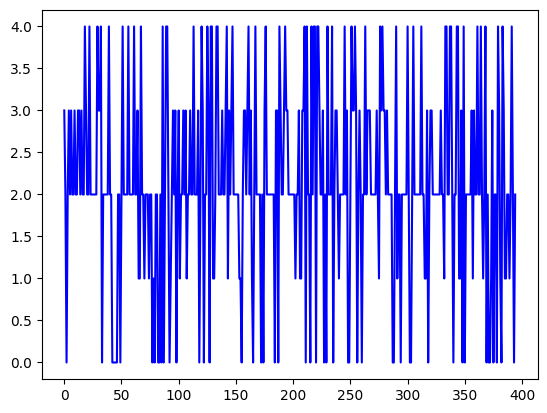

In [50]:
plt.plot(range(len(y_prediction)), y_prediction[:], "-b", label = f"Predicted")

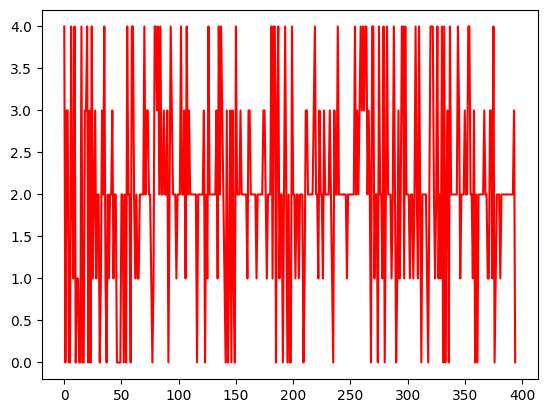

In [51]:
plt.plot(range(len(y_prediction)), y_test[:], "-r", label = f"Actual")

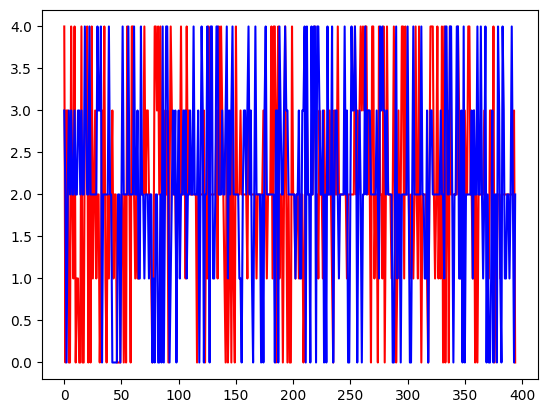

In [52]:
plt.plot(range(len(y_prediction)), y_test[:], "-r", label = f"Actual")
plt.plot(range(len(y_prediction)), y_prediction[:], "-b", label = f"Predicted")
plt.show()

In [53]:
print(pos:=np.where(np.abs(y_prediction-y_test) == 1)[0].shape[0]+np.where(y_prediction == y_test)[0].shape[0])
print(np.where(y_prediction != y_test)[0].shape[0] - np.where(np.abs(y_prediction-y_test) == 1)[0].shape[0])
print(np.where(np.abs(y_prediction-y_test) > 2)[0].shape[0])
print(np.where(np.abs(y_prediction-y_test) > 3)[0].shape[0])
print(all:=y_prediction.shape[0])

223
172
47
10
395


In [57]:
np.where(y_test == 0)[0]

array([  1,   4,   5,  10,  13,  14,  16,  17,  21,  23,  31,  37,  46,
        47,  48,  49,  52,  54,  58,  77,  91, 116, 123, 141, 143, 146,
       149, 185, 191, 195, 197, 198, 209, 235, 268, 274, 280, 290, 312,
       318, 331, 333, 336, 359, 361, 376, 394])

In [54]:
pos/all

0.5645569620253165

In [60]:
def foo(y_test, y_prediction):
    y_test = y_test-2
    y_prediction = y_prediction-2

In [61]:
foo(y_test, y_prediction)

AttributeError: 'tuple' object has no attribute 'shape'

In [201]:
import datetime

model.save(os.path.join(MODEL_LSTM_CLASS_OUTPUT_DIR, f"{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.h5"))

# LSTM Regression

In [98]:
NUMBER_OF_TRAINING_DATA = 10
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "reg", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "reg", "labels.npy"), allow_pickle=True)[-900:]


INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('float32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



FileNotFoundError: [Errno 2] No such file or directory: '../data_collection/datasets/training/reg/features.npy'

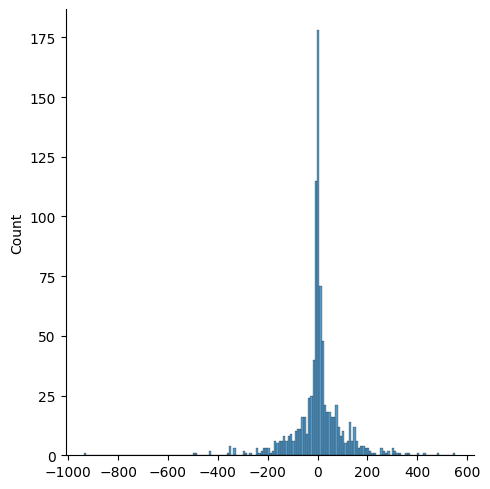

In [627]:
import seaborn as sns

sns.displot(y_training)

In [24]:
def create_lstm_regression_model(input_shape:Tuple[int, int]) -> tf.keras.Model:
    """Creates a regression model with LSTM layers."""
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.LSTM(64, activation="tanh", dropout=0.1, return_sequences=True),
        tf.keras.layers.LSTM(86, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(128, activation="tanh"),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        # loss=weightedLoss(class_weights),
        loss=tf.keras.losses.MeanSquaredLogarithmicError(),
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005, epsilon=3e-03),
        metrics=["mae"]
    )

    return model

In [25]:
model = create_lstm_regression_model(INPUT_DIM)

In [26]:
history = model.fit(x_training, y_training, validation_split=VALIDATION_SPLIT, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
13/13 [==============================] - 3s 86ms/step - loss: 4.6573 - mae: 57.5814 - val_loss: 4.5890 - val_mae: 79.9487
Epoch 2/50
13/13 [==============================] - 0s 25ms/step - loss: 3.6192 - mae: 57.9958 - val_loss: 4.6174 - val_mae: 79.9592
Epoch 3/50
13/13 [==============================] - 0s 22ms/step - loss: 3.5529 - mae: 57.7815 - val_loss: 4.7853 - val_mae: 80.0045
Epoch 4/50
13/13 [==============================] - 0s 23ms/step - loss: 3.5812 - mae: 57.6759 - val_loss: 4.7585 - val_mae: 80.0001
Epoch 5/50
13/13 [==============================] - 0s 23ms/step - loss: 3.5509 - mae: 57.7370 - val_loss: 4.7354 - val_mae: 79.9982
Epoch 6/50
13/13 [==============================] - 0s 22ms/step - loss: 3.5420 - mae: 57.7283 - val_loss: 4.7485 - val_mae: 80.0071
Epoch 7/50
13/13 [==============================] - 0s 21ms/step - loss: 3.5301 - mae: 57.7166 - val_loss: 4.7772 - val_mae: 80.0177
Epoch 8/50
13/13 [==============================] - 0s 22ms/step - lo

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 23, 64)            25856     
                                                                 
 lstm_7 (LSTM)               (None, 23, 86)            51944     
                                                                 
 lstm_8 (LSTM)               (None, 128)               110080    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 188,009
Trainable params: 188,009
Non-trainable params: 0
_________________________________________________________________


In [28]:
accuracy = history.history["mae"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

KeyError: 'val_acc'

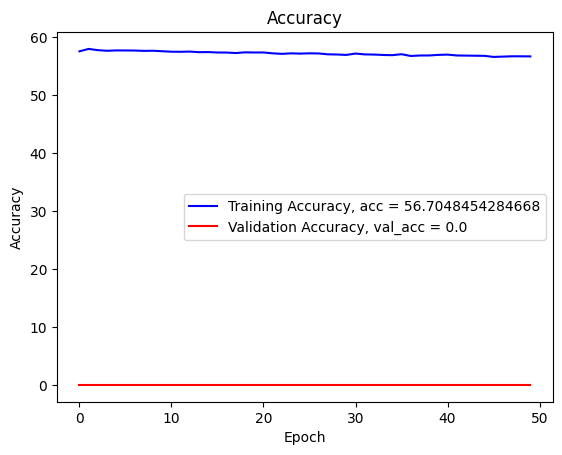

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

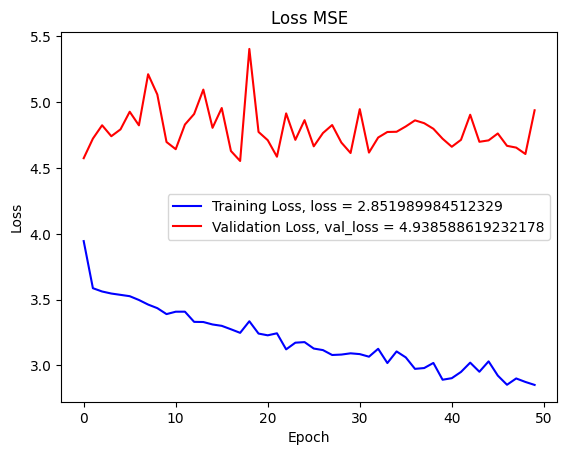

In [30]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [31]:
x_test = np.load(os.path.join(TEST_PATH, "reg", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "reg", "labels.npy"), allow_pickle=True)

INPUT_DIM = x_test.shape[1:]

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('float32'))
# y_test = tf.one_hot(y_test, 5)

In [32]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 12ms/step - loss: 3.9227 - mae: 47.5587


[3.922714948654175, 47.5587043762207]